In [ ]:
!pip -q install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, zipfile, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()

In [ ]:
csv_30 = glob.glob("/content/drive/MyDrive/1:1_Srinithi_Rajan/Dataset/Data/CSV files/features_30_sec.csv", recursive = True)[0]

In [ ]:
csv_3 = glob.glob("/content/drive/MyDrive/1:1_Srinithi_Rajan/Dataset/Data/CSV files/features_3_sec.csv", recursive = True)[0]

In [ ]:
csv_30

'/content/drive/MyDrive/1:1_Srinithi_Rajan/Dataset/Data/CSV files/features_30_sec.csv'

In [ ]:
csv_3

'/content/drive/MyDrive/1:1_Srinithi_Rajan/Dataset/Data/CSV files/features_3_sec.csv'

In [ ]:
from IPython.display import display

def _clean_df(df: pd.DataFrame) -> pd.DataFrame:
    # Some CSVs contain an index column like 'Unnamed: 0'
    if df.columns[0].lower().startswith("unnamed"):
        df = df.drop(columns=[df.columns[0]])
    return df


def train_knn_with_group_split(csv_path, k=19, test_size=0.30, seed=42):
    df = _clean_df(pd.read_csv(csv_path))

    assert "label" in df.columns, "Expected a 'label' column"
    assert "filename" in df.columns, "Expected a 'filename' column"

    feature_cols = [c for c in df.columns if c not in ["filename", "label"]]

    X_raw = df[feature_cols]
    y = df["label"].astype(str).str.lower()
    groups = df["filename"].astype(str)

    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    train_idx, test_idx = next(splitter.split(X_raw, y, groups=groups))

    X_train_raw = X_raw.iloc[train_idx]
    X_test_raw  = X_raw.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=feature_cols, index=X_train_raw.index)
    X_test  = pd.DataFrame(scaler.transform(X_test_raw),      columns=feature_cols, index=X_test_raw.index)

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    # SHAP explainer (keep background small for speed)
    background = shap.utils.sample(X_train, 200, random_state=seed) if len(X_train) > 200 else X_train
    explainer = shap.Explainer(
        model.predict_proba,
        background,
        feature_names=X_train.columns,
        output_names=list(model.classes_)
    )

    # Pack everything we need
    out = {
        "df": df,
        "feature_cols": feature_cols,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "filenames_train": df.loc[X_train.index, "filename"].astype(str),
        "filenames_test": df.loc[X_test.index, "filename"].astype(str),
        "model": model,
        "scaler": scaler,
        "explainer": explainer,
        "k": k,
    }
    return out


def eval_and_plot_confusion(ctx, title=""):
    model = ctx["model"]
    X_test = ctx["X_test"]
    y_test = ctx["y_test"]
    preds = model.predict(X_test)

    print(f"\n=== {title} ===")
    print(classification_report(y_test, preds, digits=3))

    labels = sorted(y_test.unique())
    cm = confusion_matrix(y_test, preds, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels, fmt='.2f')
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def topk_probs(model, x_row, k=3):
    proba = model.predict_proba([x_row])[0]
    pairs = sorted(zip(model.classes_, proba), key=lambda t: -t[1])[:k]
    return pairs


def neighbor_table(ctx, x_row, n_neighbors=None):
    model = ctx["model"]
    X_train = ctx["X_train"]
    y_train = ctx["y_train"]
    f_train = ctx["filenames_train"]
    k = n_neighbors or ctx["k"]

    dists, idxs = model.kneighbors([x_row], n_neighbors=k, return_distance=True)
    dists, idxs = dists[0], idxs[0]

    neigh = pd.DataFrame({
        "rank": np.arange(1, k+1),
        "distance": dists,
        "neighbor_label": y_train.iloc[idxs].values,
        "neighbor_filename": f_train.iloc[idxs].values,
    })

    display(neigh.head(12))
    print("\nNeighbor label counts:\n", neigh["neighbor_label"].value_counts())
    return neigh


def explain_instance(ctx, x_row, class_name=None, max_display=20):
    model = ctx["model"]
    explainer = ctx["explainer"]

    pred = model.predict([x_row])[0]
    chosen = class_name if class_name is not None else pred
    class_idx = list(model.classes_).index(chosen)

    sv = explainer(pd.DataFrame([x_row], columns=ctx["X_train"].columns))
    print("Pred:", pred, "| Top-3:", topk_probs(model, x_row, 3))

    shap.plots.bar(sv[0, :, class_idx], max_display=max_display)
    shap.plots.waterfall(sv[0, :, class_idx], max_display=max_display)
    return sv, class_idx

In [ ]:
gt30 = train_knn_with_group_split(csv_30, k = 19, test_size = 0.30, seed = 42)

In [ ]:
gt3 = train_knn_with_group_split(csv_3, k = 19, test_size = 0.30, seed = 42)


=== GTZAN 30 - KNN ===
              precision    recall  f1-score   support

       blues      0.910     0.853     0.880       638
   classical      0.892     0.961     0.925       616
     country      0.804     0.869     0.835       578
       disco      0.789     0.897     0.840       602
      hiphop      0.917     0.890     0.903       620
        jazz      0.887     0.859     0.873       566
       metal      0.971     0.891     0.929       606
         pop      0.936     0.873     0.903       536
      reggae      0.830     0.883     0.855       630
        rock      0.854     0.777     0.814       602

    accuracy                          0.876      5994
   macro avg      0.879     0.875     0.876      5994
weighted avg      0.879     0.876     0.876      5994



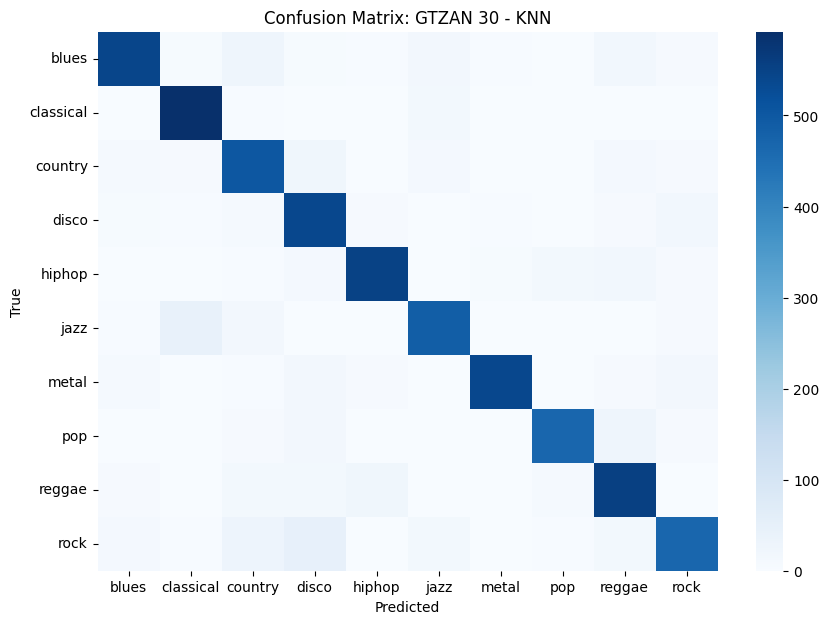

In [ ]:
eval_and_plot_confusion(gt30, title = "GTZAN 30 - KNN")


=== GTZAN 3 - KNN ===
              precision    recall  f1-score   support

       blues      0.877     0.803     0.838       319
   classical      0.860     0.958     0.906       308
     country      0.740     0.848     0.790       289
       disco      0.682     0.834     0.750       301
      hiphop      0.915     0.800     0.854       310
        jazz      0.858     0.813     0.835       283
       metal      0.926     0.832     0.877       303
         pop      0.885     0.832     0.858       268
      reggae      0.754     0.816     0.784       315
        rock      0.749     0.645     0.693       301

    accuracy                          0.818      2997
   macro avg      0.825     0.818     0.818      2997
weighted avg      0.825     0.818     0.818      2997



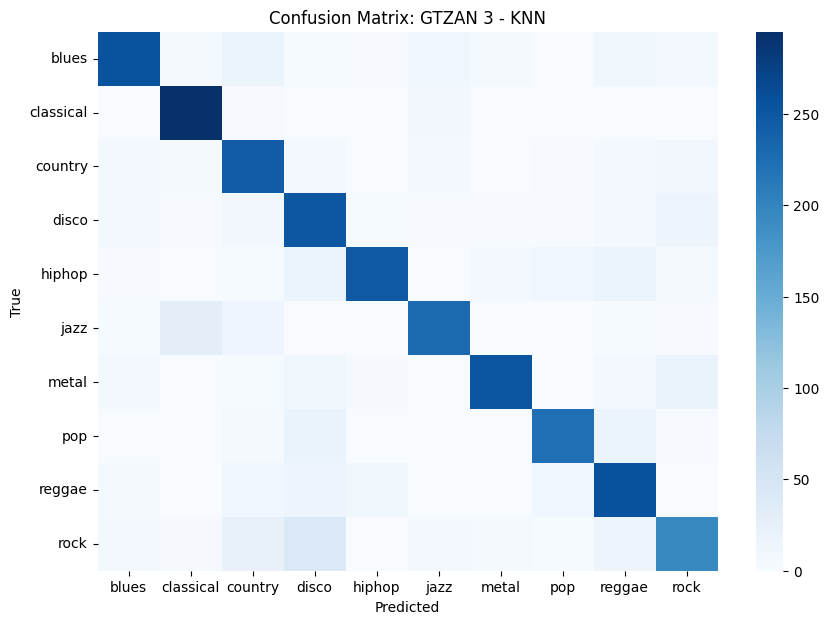

In [ ]:
eval_and_plot_confusion(gt3, title = "GTZAN 3 - KNN")

Scenario S1: The "Contextual Erasure" (Temporal Decay) (2 sessions)
A direct comparison of SHAP feature importance for the same KNN prediction at 3s and 30s
Respective code for the scenario using SHAP

In [ ]:
df30_test = gt30["df"].loc[gt30["X_test"].index].copy()

In [ ]:
df3_test = gt3["df"].loc[gt3["X_test"].index].copy()

In [ ]:
df30_test["pred"] = gt30["model"].predict(gt30["X_test"])

In [ ]:
df3_test["pred"] = gt3["model"].predict(gt3["X_test"])

Chosen filename: country.00000.2.wav
30s row index: 1002 | 3s row index: 1002

--- SHAP @ 30s ---
Pred: country | Top-3: [('country', np.float64(0.5789473684210527)), ('pop', np.float64(0.3157894736842105)), ('rock', np.float64(0.10526315789473684))]


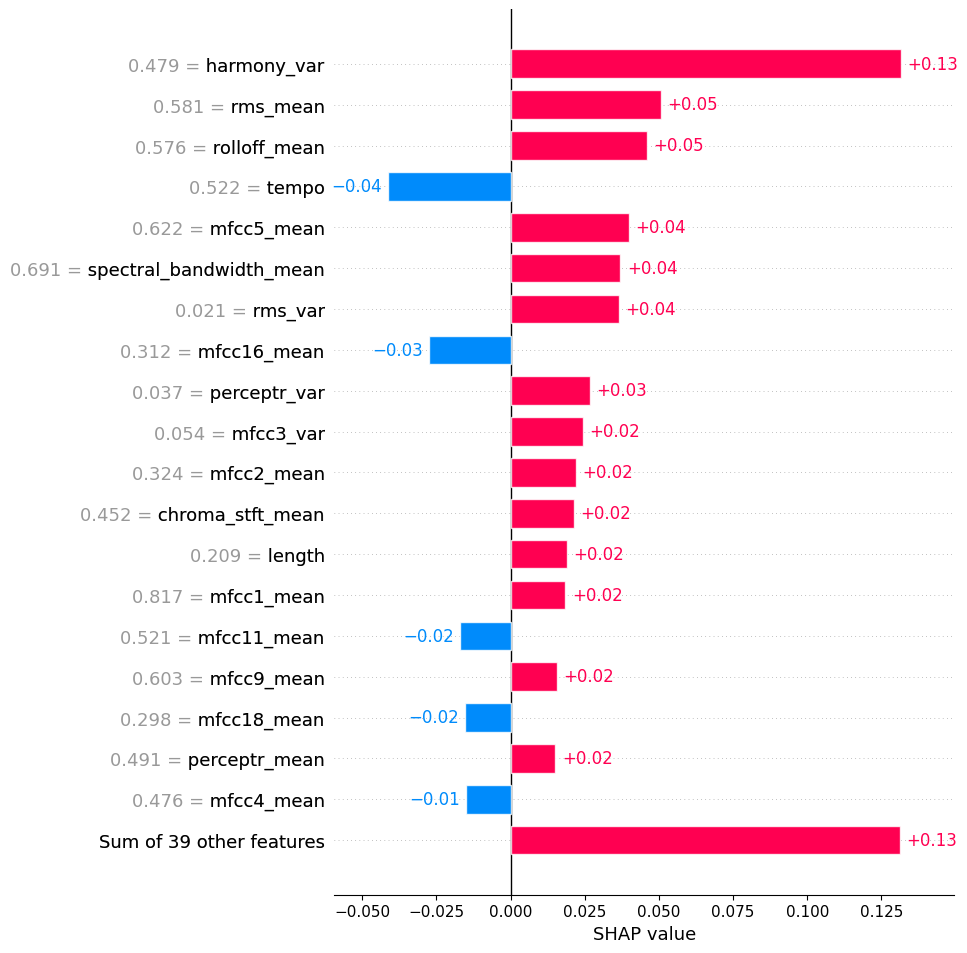

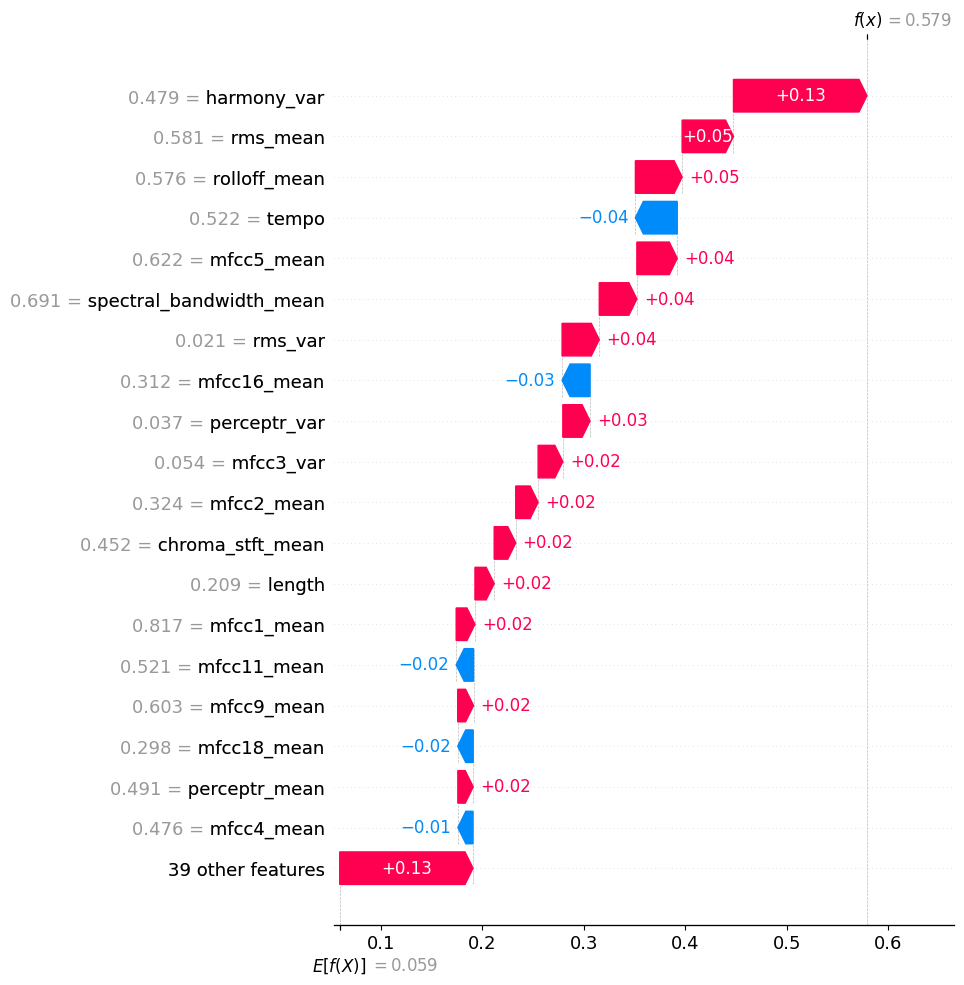


--- SHAP @ 3s ---
Pred: country | Top-3: [('country', np.float64(0.631578947368421)), ('pop', np.float64(0.21052631578947367)), ('jazz', np.float64(0.10526315789473684))]


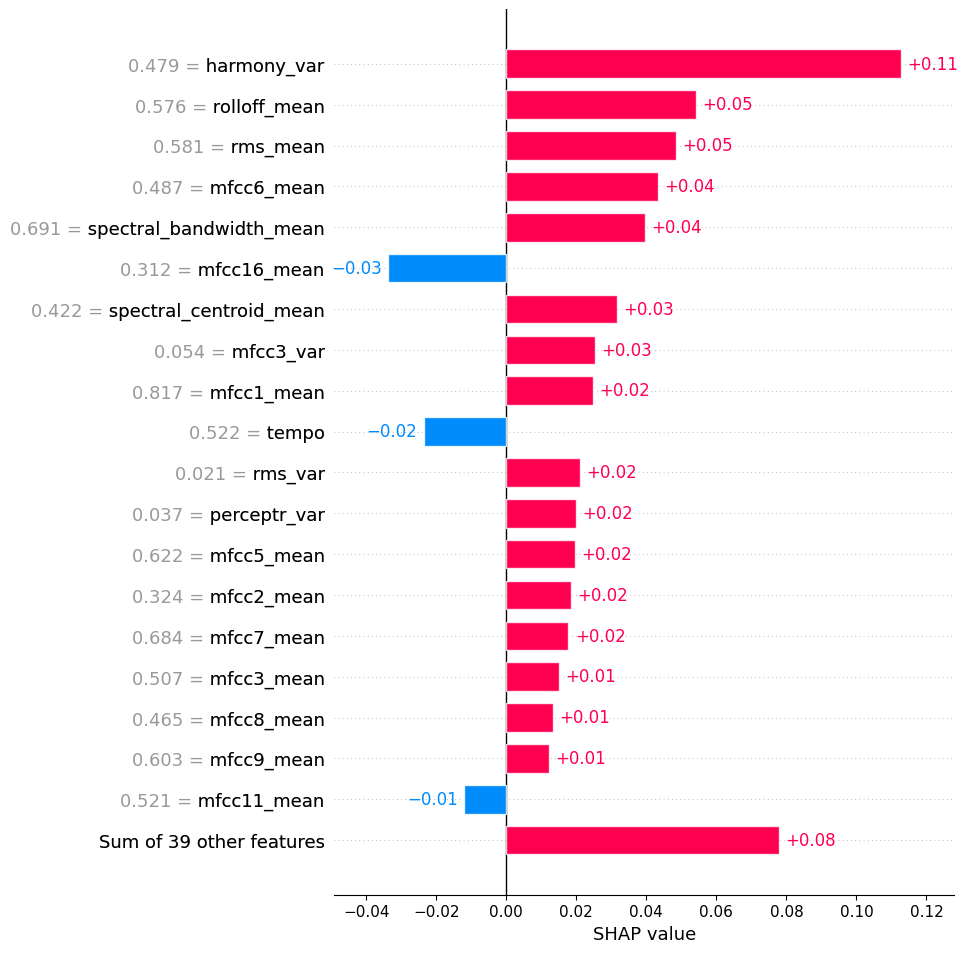

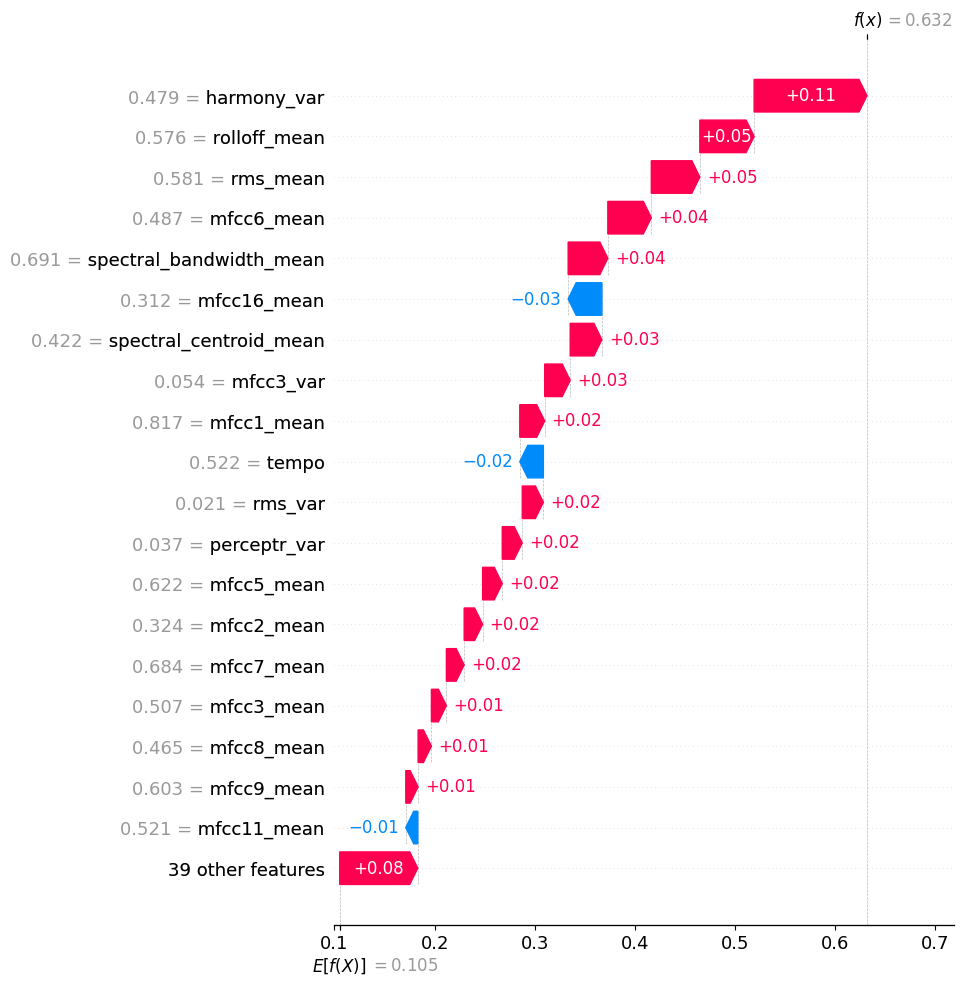


Tempo/BPM | sum(|SHAP|) @30s = 0.0412 vs @3s = 0.0236


In [ ]:
pair = None
for fname in df30_test[(df30_test["label"].str.lower()=="country") & (df30_test["pred"]=="country")]["filename"]:
    segs = df3_test[df3_test["filename"] == fname]
    if len(segs) == 0:
        continue
    seg_ok = segs[segs["pred"] == "country"]
    if len(seg_ok) == 0:
        continue
    pair = (fname, df30_test[df30_test["filename"]==fname].index[0], seg_ok.index[0])
    break
if pair is None:
    raise RuntimeError("Could not find a Country file that is predicted as Country in both 30s and 3s test sets.")
fname, idx30, idx3 = pair
print("Chosen filename:", fname)
print("30s row index:", idx30, "| 3s row index:", idx3)
x30 = gt30["X_test"].loc[idx30]
x3  = gt3["X_test"].loc[idx3]
print("\n--- SHAP @ 30s ---")
sv30, cidx30 = explain_instance(gt30, x30)
print("\n--- SHAP @ 3s ---")
sv3, cidx3 = explain_instance(gt3, x3)
tempo_cols = [c for c in gt30["X_train"].columns if ("tempo" in c.lower()) or ("bpm" in c.lower())]
if len(tempo_cols) > 0:
  cols = gt30["X_train"].columns.tolist()
  tempo_idx = [cols.index(c) for c in tempo_cols]
  imp30 = np.abs(sv30.values[0, tempo_idx, cidx30]).sum()
  imp3  = np.abs(sv3.values[0,  tempo_idx, cidx3]).sum()
  print(f"\nTempo/BPM | sum(|SHAP|) @30s = {imp30:.4f} vs @3s = {imp3:.4f}")
else:
  print("\nNo tempo/BPM column found in this feature CSV (check column names).")

Stage 3: Scenario S2: The "Heuristic Trap" (Jazz vs. Country) (2 sessions)
A Jazz track is incorrectly labeled as Country because it is "acoustically close" but "musically distant."
Respective code for the scenario using SHAP

In [ ]:
def find_misclassified(ctx, true_label = "jazz", pred_label = "country"):
  df_test = ctx["df"].loc[ctx["X_test"].index].copy()
  pred = ctx["model"].predict(ctx["X_test"])
  df_test["pred"] = pred
  mask =